### data_load_and_cleaning에서 정제한 데이터를 로드

In [24]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("trip_analysis").getOrCreate()
spark_df = spark.read.parquet("./dataset/cleaned_yellow_tripdata_2024.parquet")

In [25]:
# 데이터가 정상적으로 로드되었는지 확인
spark_df.show(5)  # 상위 5개 행 출력
spark_df.printSchema()  # 데이터 타입 확인

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----------------+-----------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|trip_duration_sec|trip_duration_min|pickup_hour|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----------------+-----------------+-----------+
|       2| 2024-10-09 18:49:49|  2024-10-09

### 여행 시간, 여행 거리의 평균 계산

In [26]:
# 평균 17.55분 택시 이용
# 평균 3.45마일 이동

df_summary = spark_df.selectExpr(
    "AVG(trip_duration_min) as avg_trip_duration",
    "AVG(trip_distance) as avg_trip_distance"
)
df_summary.show()

+------------------+-----------------+
| avg_trip_duration|avg_trip_distance|
+------------------+-----------------+
|16.769361128636085|3.448888873359144|
+------------------+-----------------+



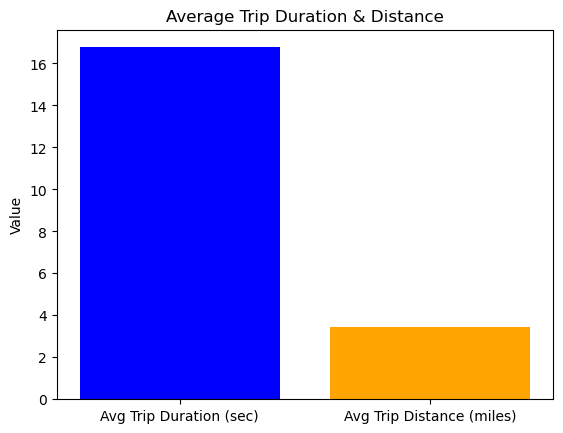

In [27]:
import matplotlib.pyplot as plt

# Spark DataFrame을 Pandas DataFrame으로 변환
summary = df_summary.toPandas()

# 데이터 시각화
fig, ax1 = plt.subplots()

ax1.bar(["Avg Trip Duration (sec)", "Avg Trip Distance (miles)"], 
        [summary["avg_trip_duration"][0], summary["avg_trip_distance"][0]], 
        color=['blue', 'orange'])

ax1.set_ylabel("Value")
ax1.set_title("Average Trip Duration & Distance")
plt.show()


### spark dataframe으로 구한 평균값을 전체적인 데이터 분포와 비교

In [28]:
# 1% 샘플링 (조정 가능)
sample_fraction = 0.01  # 1% 샘플링
sampled_spark_df = spark_df.sample(fraction=sample_fraction, seed=42)

# 샘플링된 데이터를 Pandas로 변환
pandas_df = sampled_spark_df.select("trip_duration_min", "trip_distance").toPandas()

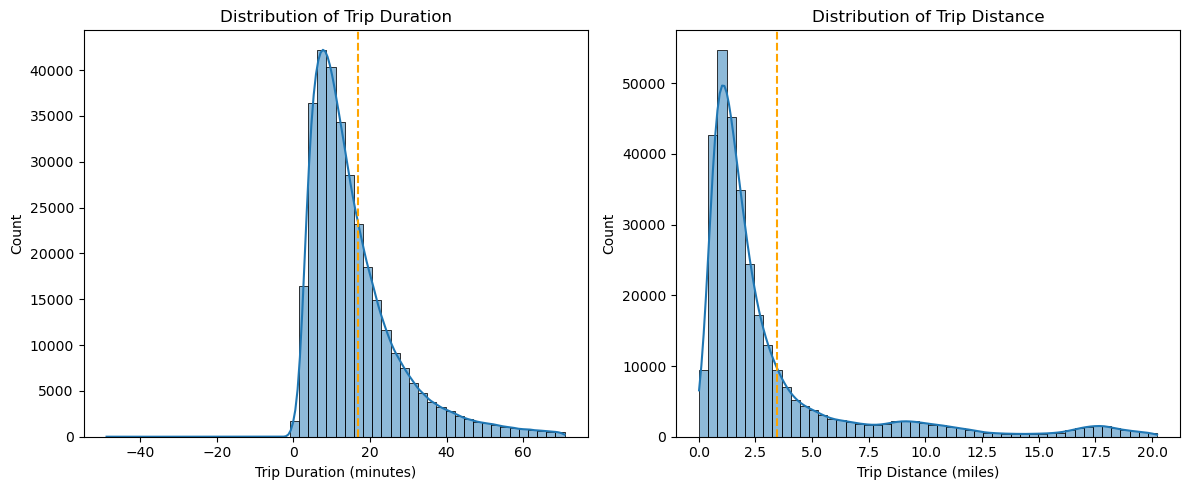

In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 99% 분위수 계산 (극단값을 제거하기 위해)
duration_99 = np.percentile(pandas_df["trip_duration_min"], 99)
distance_99 = np.percentile(pandas_df["trip_distance"], 99)

filtered_df = pandas_df[
    (pandas_df["trip_duration_min"] <= duration_99) &
    (pandas_df["trip_distance"] <= distance_99)
]

# 스파크 df로 구한 평균값
avg_trip_duration = summary["avg_trip_duration"][0]
avg_trip_distance = summary["avg_trip_distance"][0]

# 히스토그램 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(filtered_df["trip_duration_min"], bins=50, kde=True, ax=axes[0])
axes[0].axvline(avg_trip_duration, color="orange", linestyle="--", label=f"Mean: {avg_trip_duration:.2f}")
axes[0].set_title("Distribution of Trip Duration")
axes[0].set_xlabel("Trip Duration (minutes)")

sns.histplot(filtered_df["trip_distance"], bins=50, kde=True, ax=axes[1])
axes[1].axvline(avg_trip_distance, color="orange", linestyle="--", label=f"Mean: {avg_trip_distance:.2f}")
axes[1].set_title("Distribution of Trip Distance")
axes[1].set_xlabel("Trip Distance (miles)")

plt.tight_layout()
plt.show()


### 시간 당 출발하는 여행 수를 기준으로 Peak Hours 정의

In [30]:
from pyspark.sql.functions import col

# 시간별 이용량 집계
hourly_trip_counts = spark_df.groupBy("pickup_hour").count().orderBy("pickup_hour")

# 결과 확인
hourly_trip_counts.show()

+-----------+-------+
|pickup_hour|  count|
+-----------+-------+
|          0| 864571|
|          1| 569358|
|          2| 373006|
|          3| 239405|
|          4| 152058|
|          5| 179709|
|          6| 422345|
|          7| 850565|
|          8|1191919|
|          9|1378473|
|         10|1515053|
|         11|1641303|
|         12|1780197|
|         13|1847288|
|         14|1981692|
|         15|2039292|
|         16|2073080|
|         17|2237198|
|         18|2329957|
|         19|2052478|
+-----------+-------+
only showing top 20 rows



In [34]:
# 피크아워 찾기
peak_hour = pandas_df.loc[pandas_df["count"].idxmax()]
print(f"피크시간: {peak_hour['pickup_hour']}시 ({peak_hour['count']}건)")

피크시간: 18시 (2329957건)


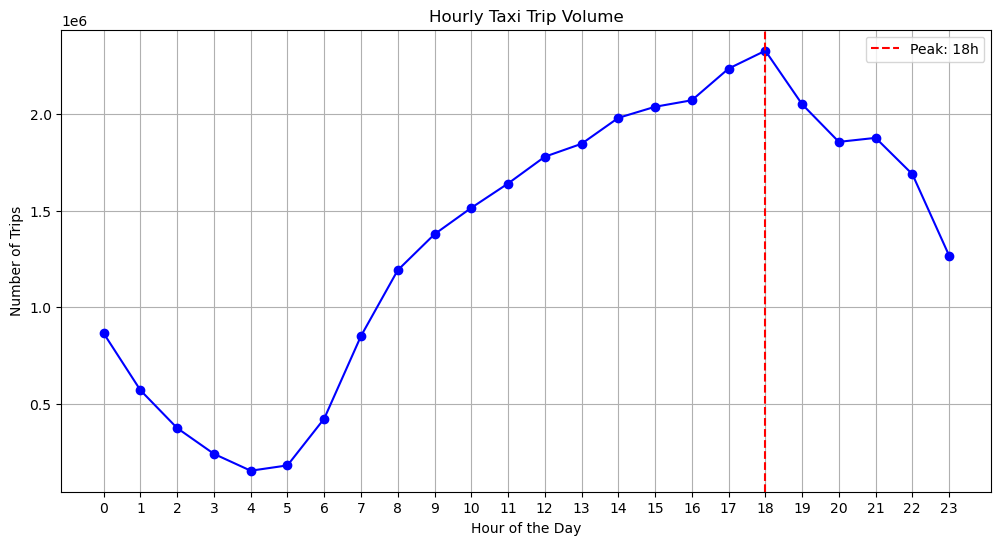

In [36]:
# Spark DF → Pandas DF 변환
pandas_df = hourly_trip_counts.toPandas()

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(pandas_df["pickup_hour"], pandas_df["count"], marker='o', linestyle='-', color='b')

# 피크시간 강조
plt.axvline(x=peak_hour["pickup_hour"], color='r', linestyle='--', label=f"Peak: {peak_hour['pickup_hour']}h")
plt.legend()

# 그래프 설정
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Trips")
plt.title("Hourly Taxi Trip Volume")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


In [31]:
spark.stop()